In [1]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import meshio

msh = meshio.read("dogbone_experiment.msh")
for cell in msh.cells:
    triangle_cells = cell.data

triangle_mesh = meshio.Mesh(points=msh.points[:, :2], cells={"triangle": triangle_cells})
meshio.write("dogbone_experiment.xdmf", triangle_mesh, file_format='xdmf')


"""
element and nodal files
"""
# # ---- Write Nodal File ----
# with open("nodal_file.txt", "w") as f:
#     for i, point in enumerate(msh.points):
#         # mesh.points is a NumPy array of shape (n_points, 3)
#         f.write(f"{i+1} {point[0]} {point[1]} {point[2]}\n")  # Node IDs start at 1

# # ---- Write Element File ----
# element_id = 1
# with open("element_file.txt", "w") as f:
#     for cell_block in msh.cells:
#         # cell_block.type could be "triangle", "tetra", etc.
#         for cell in cell_block.data:
#             # Convert to 1-based indexing for ANSYS style
#             node_ids = [str(n + 1) for n in cell]
#             f.write(f"{element_id} {' '.join(node_ids)}\n")
#             element_id += 1

# print("Exported nodal_file.txt and element_file.txt successfully.")


[R2D2:06287] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.R2D2.1000/jf.0/644349952/shared_mem_cuda_pool.R2D2 could be created.
[R2D2:06287] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


'\nelement and nodal files\n'

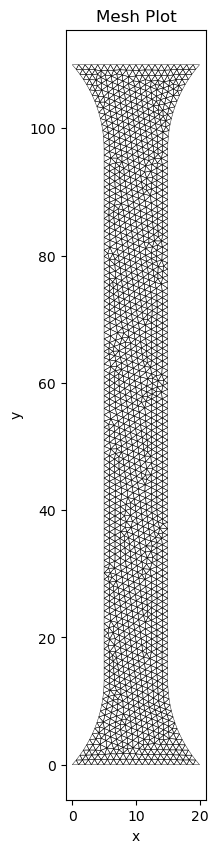

Mesh dimension: 2


In [2]:
# Load the mesh
mesh = Mesh()
with XDMFFile("dogbone_experiment.xdmf") as infile:
    infile.read(mesh)

# Extract vertices and cells from the mesh
vertices = mesh.coordinates()
cells = mesh.cells()

# Plot the mesh
plt.figure(figsize=(10, 10))
for cell in cells:
    vertices_cell = vertices[cell]
    plt.fill(vertices_cell[:, 0], vertices_cell[:, 1], edgecolor='k', linewidth=0.3, fill=False)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mesh Plot')
plt.gca().set_aspect('equal')
plt.show()

print("Mesh dimension:", mesh.geometric_dimension())

In [4]:


# Define geometry parameters
R = 20
Hmax = 110
n_mesh = 1 #lc

theta = np.arccos(15/R)
b = 10
indent_x = R - (R * np.cos(theta))
indent_y = R * np.sin(theta)
Lmax = 2*indent_x + b
free_length = 110

L_c = free_length - (2*indent_y)
H_clamp = 0
L_u = 60

total_points_vert = 140 #see geometry mapping code
total_points_hor = 40

x_max_FEM = (2*indent_x) + b
y_max_FEM = 2*H_clamp + 2*indent_y + L_c

#ROI positioning
offs_x = indent_x
offs_y = indent_y + H_clamp + (L_c-L_u)/2
x_max_ROI = b
y_max_ROI = L_u

pstress = 9 #360N (TBD exactly!!! over 20mm x 2mm)

E =69e3 # 69GPa
nu = 0.33
lambda_ = E*nu/((1+nu)*(1-2*nu))
mu = E/(2*(1+nu))

lambda_=2*mu*lambda_/(lambda_+(2*mu))

# Create the geometry with notches
plate_length = Lmax
plate_height = Hmax

# Define boundary condition
V = VectorFunctionSpace(mesh, 'P', 2)

tol = 1E-14

def top_boundary(x, on_boundary):
    return on_boundary and near(x[1], plate_height, tol)

def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)



bc1 = DirichletBC(V.sub(0), Constant(0), top_boundary)
bc2 = DirichletBC(V.sub(0), Constant(0), bottom_boundary)
bc3 = DirichletBC(V.sub(1), Constant(0), bottom_boundary)
bc = [bc1, bc2, bc3]

#mark right boundary
top = AutoSubDomain(top_boundary)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
top.mark(boundaries, 1)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define strain and stress

def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    # return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)


# Define variational problem
x = SpatialCoordinate(mesh)
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
f = Constant((0, 0))

T = Constant((0, pstress))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds(1)

# Compute solution
u = Function(V)
solve(a == L, u, bc)

tensor_space = TensorFunctionSpace(mesh, 'P', 2)
strain = project(epsilon(u), tensor_space)
stress = project(sigma(u), tensor_space)

point = np.array([10, 55])  # central coordinates
strain_at_point = strain(point)
print(strain_at_point.reshape(2,2)[0,0])
print(strain_at_point.reshape(2,2)[1,1])



Solving linear variational problem.
-8.608695752904232e-05
0.0002608695660860073


Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


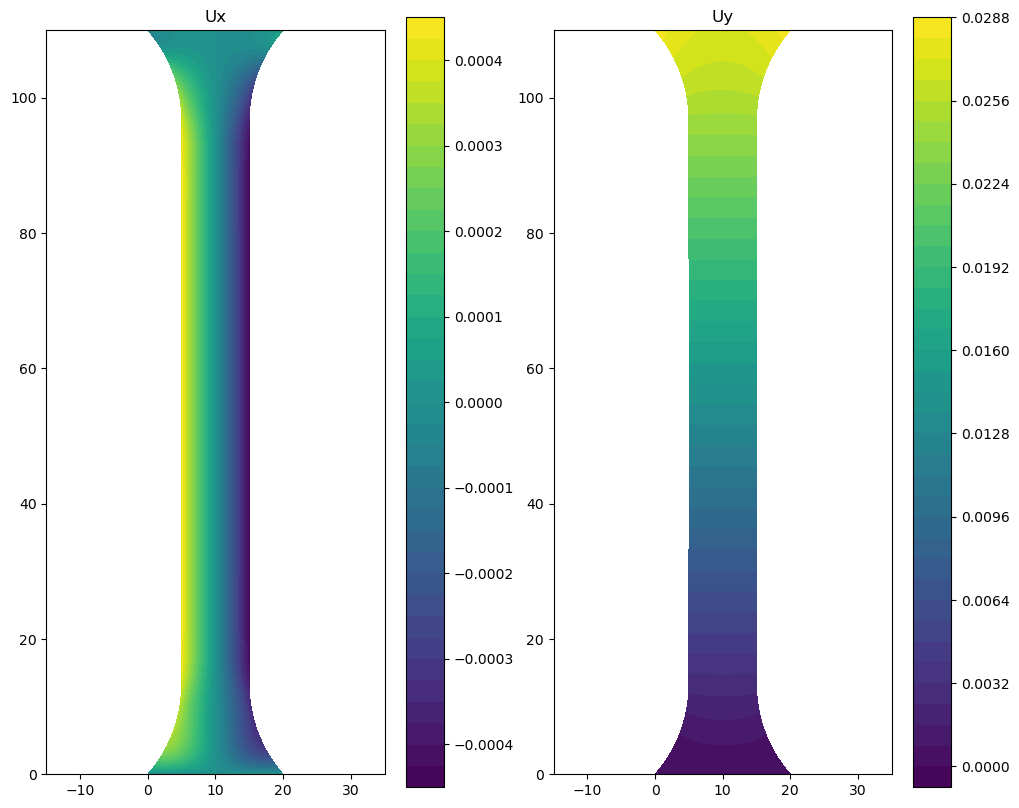

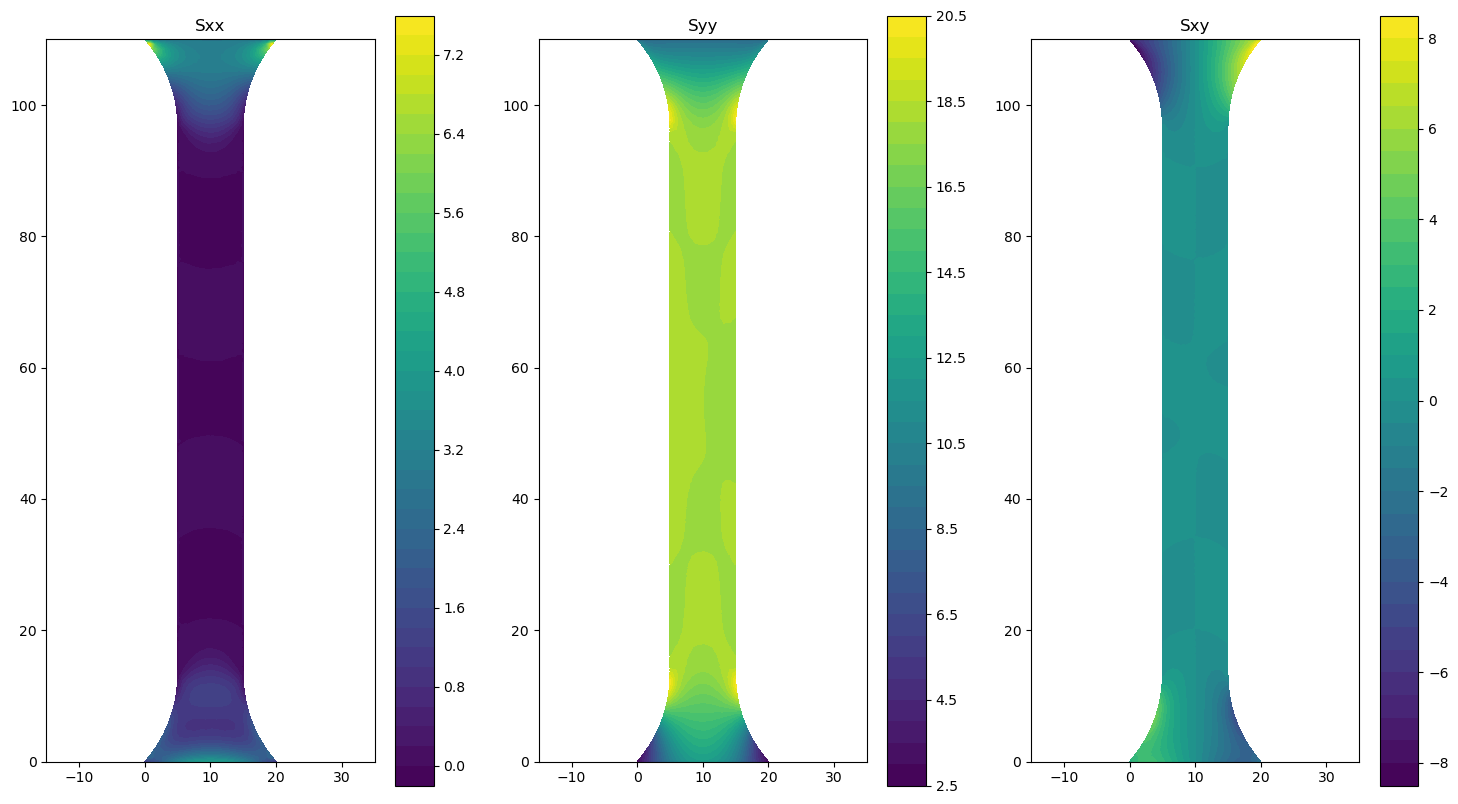

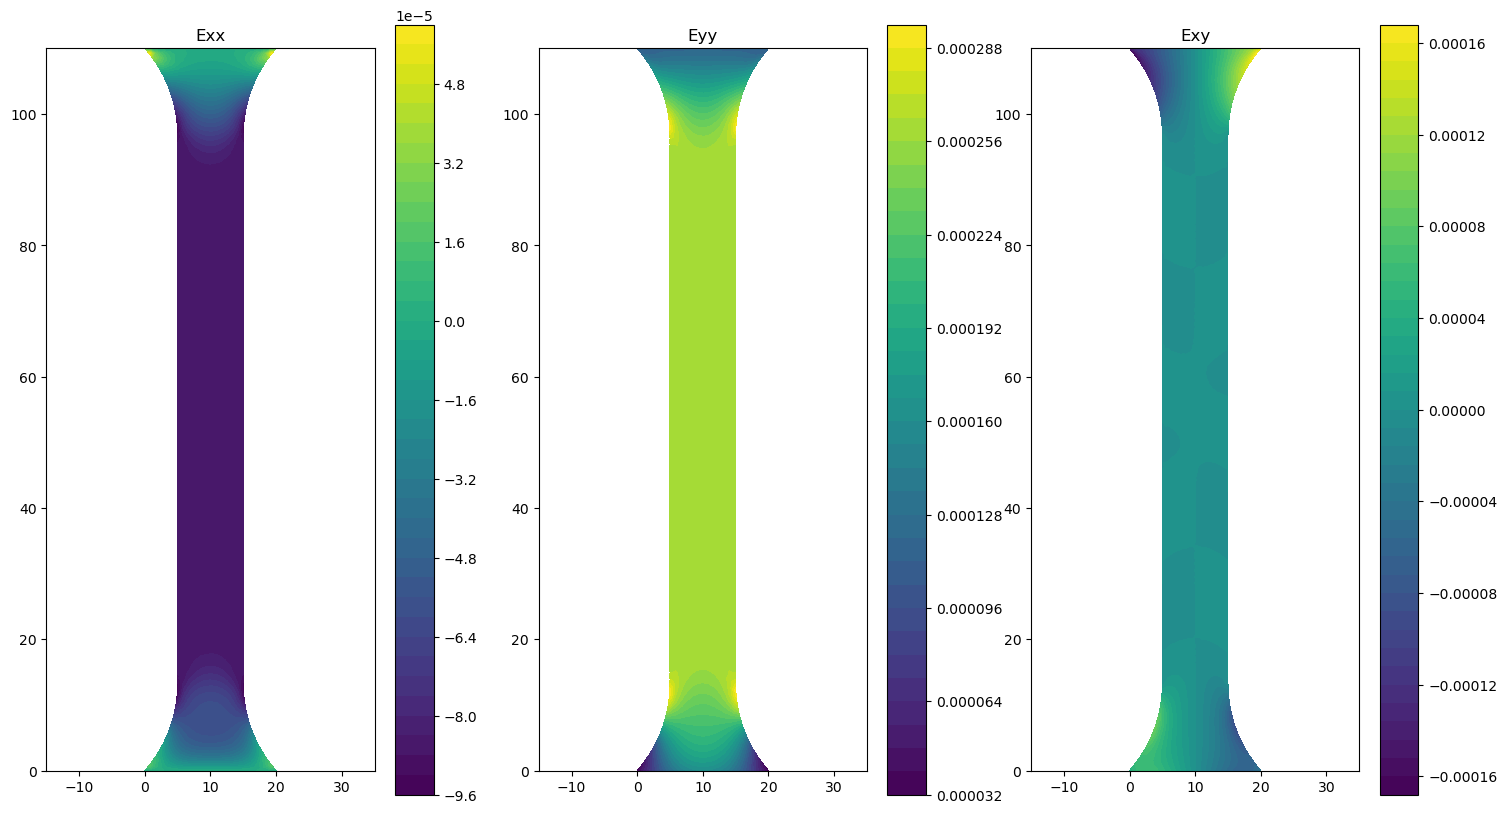

In [6]:
plt.subplots(1,2, figsize=(12, 10))

plt.subplot(121)
im = plot(u[0], mesh=mesh, title='Ux')
plt.colorbar(im)
plt.subplot(122)
im = plot(u[1], title='Uy')
plt.colorbar(im)

plt.subplots(1,3, figsize=(18, 10))
plt.subplot(131)
im = plot(stress[0, 0], title='Sxx')
plt.colorbar(im)
plt.subplot(132)
im = plot(stress[1, 1], title='Syy')
plt.colorbar(im)
plt.subplot(133)
im = plot(stress[0, 1], title='Sxy')
plt.colorbar(im)

plt.subplots(1,3, figsize=(18, 10))
plt.subplot(131)
im = plot(strain[0, 0], title='Exx')
plt.colorbar(im)
plt.subplot(132)
im = plot(strain[1, 1], title='Eyy')
plt.colorbar(im)
plt.subplot(133)
im = plot(strain[0, 1], title='Exy')
plt.colorbar(im)

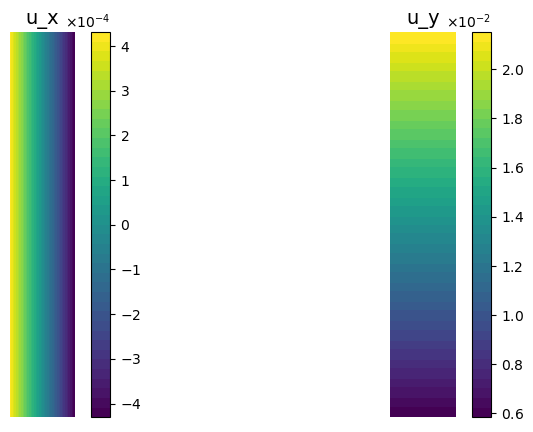

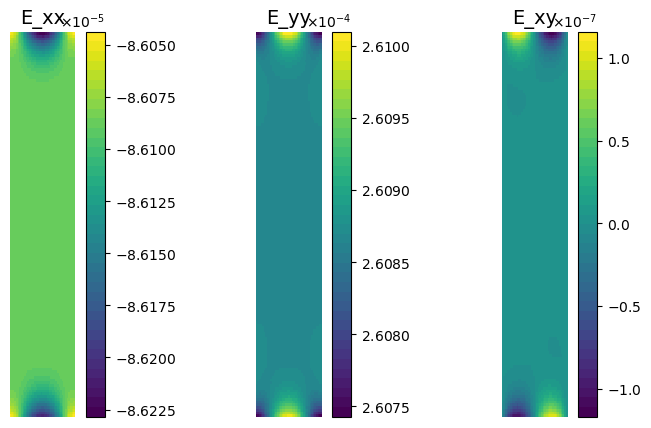

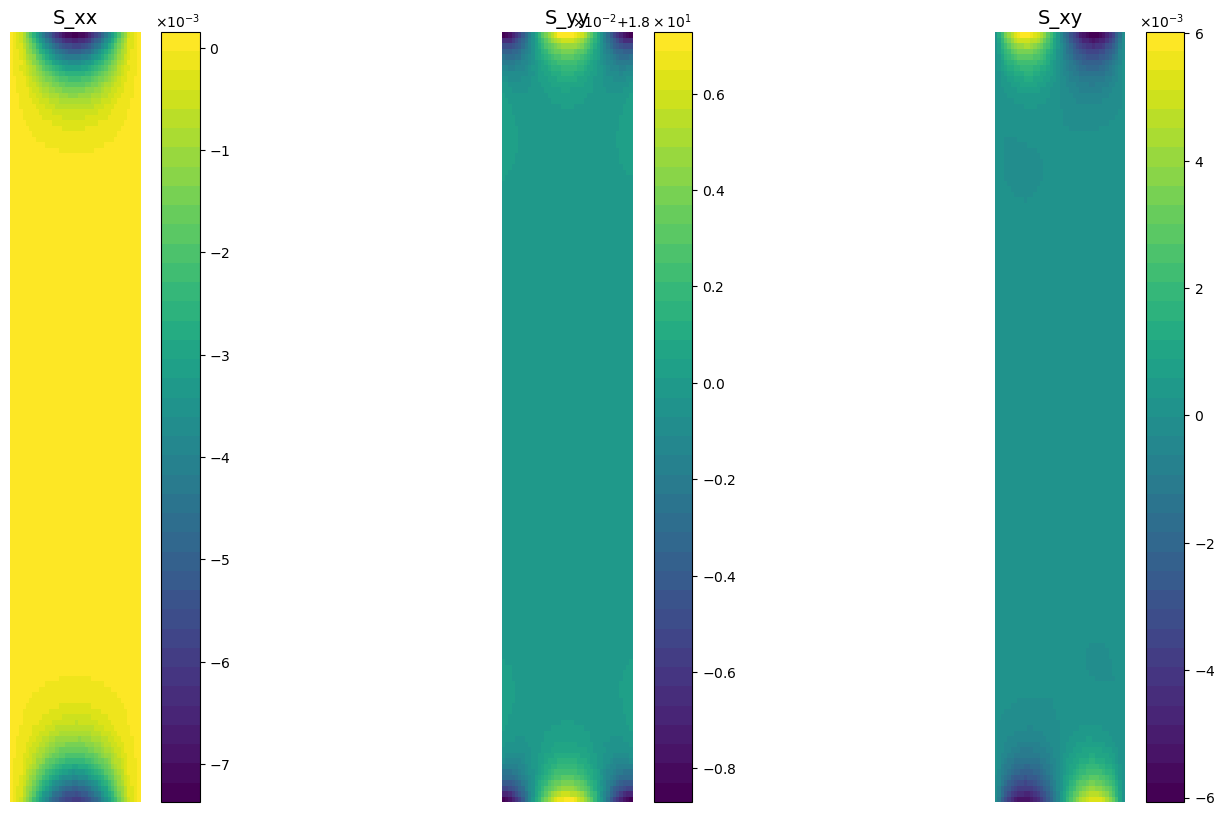

In [7]:
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Load geometry mapping
from scipy.ndimage import map_coordinates
nx= 40
ny= 140
x_max = Lmax
y_max = Hmax

Xp = np.loadtxt("./fem_data/dogbone_experiments.txt")

# Interpolate mapping
X_map_points = Xp[:, 0].reshape((ny, nx)).T
Y_map_points = Xp[:, 1].reshape((ny, nx)).T

def geometry_mapping(x,y,padding=1e-6):
    x_pos = x/x_max*(nx-1)*(1-2*padding) + padding
    y_pos = y/y_max*(ny-1)*(1-2*padding) + padding

    x_mapped = map_coordinates(X_map_points, [x_pos, y_pos], order=1)
    y_mapped = map_coordinates(Y_map_points, [x_pos, y_pos], order=1)

    return x_mapped, y_mapped


def pcolor_plot(AX, X, Y, C, title,colormap="copper",set_axis = 'off',colorbar=True,**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.set_aspect("equal", "box")
    AX.axis(set_axis)
    AX.set_title(title, fontsize=14)
    fig.colorbar(im, ax=AX, format=formatter)
    return im

cmap = plt.get_cmap('viridis')
num_colors = 40
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = ListedColormap(color_values)

"""
PLOTTING ENTIRE SPECIMEN
"""
# n_mesh_x = 40
# n_mesh_y = 140

# x_plot = np.linspace(0, Lmax, n_mesh_x)
# y_plot = np.linspace(0, Hmax, n_mesh_y)
# X, Y = np.meshgrid(x_plot, y_plot)

# X, Y = geometry_mapping(X, Y)

# X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# u_val = np.array([u(X_grid[i, :]) for i in range(X_grid.shape[0])])
# strain_val = np.array([strain(X_grid[i, :]) for i in range(X_grid.shape[0])])
# strain_val = np.array([strain_val[:,0], strain_val[:,3], 0.5*(strain_val[:,1]+strain_val[:,2])]).T
# stress_val = np.array([stress(X_grid[i, :]) for i in range(X_grid.shape[0])])
# stress_val = np.array([stress_val[:,0], stress_val[:,3], 0.5*(stress_val[:,1]+stress_val[:,2])]).T

# # # Plot displacement
# fig, ax = plt.subplots(1, 2, figsize=(9, 5))
# im = pcolor_plot(ax[0], X, Y, u_val[:,0].reshape(X.shape), "u_x",colormap=cmap)
# im = pcolor_plot(ax[1], X, Y, u_val[:,1].reshape(X.shape), "u_y",colormap=cmap)

# # # Plot strain
# fig, ax = plt.subplots(1, 3, figsize=(9, 5))
# im = pcolor_plot(ax[0], X, Y, strain_val[:,0].reshape(X.shape), "E_xx",colormap=cmap)
# im = pcolor_plot(ax[1], X, Y, strain_val[:,1].reshape(X.shape), "E_yy",colormap=cmap)
# im = pcolor_plot(ax[2], X, Y, strain_val[:,2].reshape(X.shape), "E_xy",colormap=cmap)

# # Plot stress
# fig, ax = plt.subplots(1, 3, figsize=(18, 10))
# im = pcolor_plot(ax[0], X, Y, stress_val[:,0].reshape(X.shape), "S_xx",colormap=cmap)
# im = pcolor_plot(ax[1], X, Y, stress_val[:,1].reshape(X.shape), "S_yy",colormap=cmap)
# im = pcolor_plot(ax[2], X, Y, stress_val[:,2].reshape(X.shape), "S_xy",colormap=cmap)

# plt.show()

"""
PLOTTING ROI
"""
n_mesh_x = 40
n_mesh_y = 140

x_plot = np.linspace(offs_x, offs_x + x_max_ROI, n_mesh_x)
y_plot = np.linspace(offs_y, offs_y + y_max_ROI, n_mesh_y)
X, Y = np.meshgrid(x_plot, y_plot)

#X, Y = geometry_mapping(X, Y)

X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

u_val = np.array([u(X_grid[i, :]) for i in range(X_grid.shape[0])])
strain_val = np.array([strain(X_grid[i, :]) for i in range(X_grid.shape[0])])
strain_val = np.array([strain_val[:,0], strain_val[:,3], 0.5*(strain_val[:,1]+strain_val[:,2])]).T
stress_val = np.array([stress(X_grid[i, :]) for i in range(X_grid.shape[0])])
stress_val = np.array([stress_val[:,0], stress_val[:,3], 0.5*(stress_val[:,1]+stress_val[:,2])]).T

# # Plot displacement
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
im = pcolor_plot(ax[0], X, Y, u_val[:,0].reshape(X.shape), "u_x",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, u_val[:,1].reshape(X.shape), "u_y",colormap=cmap)

# # Plot strain
fig, ax = plt.subplots(1, 3, figsize=(9, 5))
im = pcolor_plot(ax[0], X, Y, strain_val[:,0].reshape(X.shape), "E_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, strain_val[:,1].reshape(X.shape), "E_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, strain_val[:,2].reshape(X.shape), "E_xy",colormap=cmap)

# Plot stress
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
im = pcolor_plot(ax[0], X, Y, stress_val[:,0].reshape(X.shape), "S_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, stress_val[:,1].reshape(X.shape), "S_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, stress_val[:,2].reshape(X.shape), "S_xy",colormap=cmap)

plt.show()


In [8]:
print(f"Ux_mean = {np.mean(u_val[:,0]):2e} ; Uy_mean = {np.mean(u_val[:,1]):2e}")
print(f"Exx_mean = {np.mean(strain_val[:,0]):2e} ; Eyy_mean = {np.mean(strain_val[:,1]):2e} ; Exy_mean = {np.mean(strain_val[:,2]):2e}")
print(f"Sxx_mean = {np.mean(stress_val[:,0]):2e} ; Syy_mean = {np.mean(stress_val[:,1]):2e} ; Sxy_mean = {np.mean(stress_val[:,2]):2e}")

Ux_mean = -5.231153e-09 ; Uy_mean = 1.367408e-02
Exx_mean = -8.609174e-05 ; Eyy_mean = 2.608710e-04 ; Exy_mean = -5.380858e-14
Sxx_mean = -3.334751e-04 ; Syy_mean = 1.799999e+01 ; Sxy_mean = -2.791573e-09


(1597, 2)
(2908, 3)


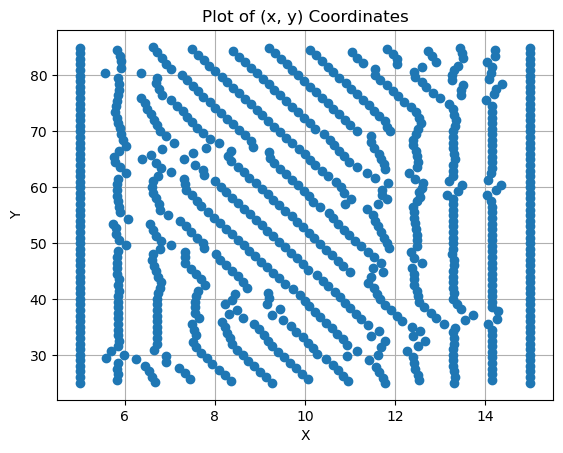

[-8.78914905e-23 -2.12918818e-23]
[-8.78914905e-23 -2.12918818e-23]
[0.00038138 0.00276676]
[0.0003769  0.02457487]
[1.47187941e-18 2.86171644e-02]
[1.47187941e-18 2.86171644e-02]
[-5.46332249e-21  2.86171594e-02]
[-5.46332249e-21  2.86171594e-02]
[-0.00037686  0.02457487]
[-0.00038144  0.00276677]
[-4.33801829e-21  1.92854617e-21]
[-4.33801829e-21  1.92854617e-21]
[7.13023732e-05 3.23332899e-05]
[1.50282659e-04 8.07236672e-05]
[0.00021641 0.00014894]
[0.00026514 0.00024345]
[0.00029769 0.00036727]
[0.00031729 0.0005206 ]
[0.00032777 0.00070201]
[0.0003326  0.00090905]
[0.00033488 0.0011381 ]
[0.00033676 0.00138604]
[0.00033972 0.00164905]
[0.00034485 0.00192341]
[0.00035301 0.00220527]
[0.00036501 0.00248908]
[0.00039799 0.00303924]
[0.00040984 0.0033022 ]
[0.00041785 0.00356206]
[0.00042314 0.00382068]
[0.0004265  0.00407892]
[0.00042853 0.00433717]
[0.0004297  0.00459562]
[0.00043031 0.0048543 ]
[0.00043059 0.0051132 ]
[0.00043069 0.00537227]
[0.00043069 0.00563147]
[0.00043066 0.00

In [47]:
# Save solution 
np.savetxt("fem_solution_dogbone_experiments_ROI.dat", np.hstack((X_grid, u_val, strain_val, stress_val)), delimiter=' ')

"""
WORKING CODE
"""

# data_dir = "fem_data"
# data_name = "dogbone_ROI"
# data_path = f"{data_dir}/{data_name}"

# # Get the deformed coordinates
# coordinates = mesh.coordinates()

# #checks
# print(coordinates.shape)
# print(mesh.cells().shape)
# coordinates= coordinates[~((coordinates[:, 0] < -1) | (coordinates[:, 0] > 21))]
# plt.plot(coordinates[:,0], coordinates[:,1], marker='o', linestyle='None')
# plt.title("Plot of (x, y) Coordinates")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.grid(True)
# plt.show()

# u_mesh = np.array([u(point) for point in coordinates])
# deformed_coordinates = coordinates + u_mesh
# deformed_coordinates_updown = coordinates + np.array([u_mesh[::-1,0], u_mesh[::-1,1]]).T

# # Save the mesh
# with open(data_path+".mesh", "w") as mesh_file:
#     # Write node data
#     mesh_file.write("*Part name=MatchID Part\n*Node\n")
#     for idx, coord in enumerate(coordinates, start=1):
#         mesh_file.write(f"{idx};{coord[0]:.8f};{coord[1]:.8f};0.0\n")
    
#     # Write element data
#     mesh_file.write("*Element\n")
#     for idx, cell in enumerate(mesh.cells(), start=1):
#         element_data = ";".join(str(node + 1) for node in cell)  # Add 1 to make node indices 1-based
#         mesh_file.write(f"{idx};{element_data}\n")

# #save the node data
# with open(data_path+".csv", "w") as node_file:
#     node_file.write("*Part name=MatchID Part\n*Node\n")
#     for idx, coord in enumerate(deformed_coordinates, start=1):
#         node_file.write(f"{idx};{coord[0]:.8f};{coord[1]:.8f};0.0\n")

"""
TEST CODE --> WORKS FOR FULL DOMAIN
"""

# data_dir = "fem_data"
# data_name = "dogbone_ROI"
# data_path = f"{data_dir}/{data_name}"

# # Get the deformed coordinates
# coordinates = mesh.coordinates()

# #checks
# print(coordinates.shape)
# print(mesh.cells().shape)

# # Save the mesh
# with open(data_path+".mesh", "w") as mesh_file:
#     # Write node data
#     mesh_file.write("*Part name=MatchID Part\n*Node\n")
#     for idx, coord in enumerate(coordinates, start=1):
#         if -1 < coord[0] < 21:
#             mesh_file.write(f"{idx};{coord[0]:.8f};{coord[1]:.8f};0.0\n")
    
#     # Write element data
#     mesh_file.write("*Element\n")
#     for idx, cell in enumerate(mesh.cells(), start=1):
#         element_data = ";".join(str(node + 1) for node in cell)  # Add 1 to make node indices 1-based
#         mesh_file.write(f"{idx};{element_data}\n")

# u_mesh = []
# for point in coordinates:
#     if -1 < point[0] < 21:
#         value = u(point)
#     else:
#         value = [0.0,0.0]
#     u_mesh.append(value)
    

# u_mesh = np.array(u_mesh)
# deformed_coordinates = coordinates + u_mesh
# deformed_coordinates_updown = coordinates + np.array([u_mesh[::-1,0], u_mesh[::-1,1]]).T


# #save the node data
# with open(data_path+".csv", "w") as node_file:
#     node_file.write("*Part name=MatchID Part\n*Node\n")
#     for idx, coord in enumerate(deformed_coordinates, start=1):
#         if -1 < coord[0] < 21:
#             node_file.write(f"{idx};{coord[0]:.8f};{coord[1]:.8f};0.0\n")


# print(deformed_coordinates - coordinates)


"""
TEST CODE: ROI
"""

data_dir = "fem_data"
data_name = "dogbone_ROI"
data_path = f"{data_dir}/{data_name}"

# Get the deformed coordinates
coordinates = mesh.coordinates()

#checks
print(coordinates.shape)
print(mesh.cells().shape)

# Save the mesh
with open(data_path+".mesh", "w") as mesh_file:

    new_coords = []
    # Write node data
    mesh_file.write("*Part name=MatchID Part\n*Node\n")
    for idx, coord in enumerate(coordinates, start=1):
        if 25 <= coord[1] <= 85:
            if -1 < coord[0] < 21:
                new_coords.append(coord)
                mesh_file.write(f"{idx};{coord[0]:.8f};{coord[1]:.8f};0.0\n")
    
    # Write element data
    mesh_file.write("*Element\n")
    out = False
    for idx, cell in enumerate(mesh.cells(), start=1):
        out = False
        for node in cell:
            if 85 <= coordinates[node][1] or coordinates[node][1] <= 25:
                #print(coordinates[node][1])
                out = True
        if not out:
            element_data = ";".join(str(node + 1) for node in cell)  # Add 1 to make node indices 1-based
            mesh_file.write(f"{idx};{element_data}\n")



new_coords = np.array(new_coords)
plt.plot(new_coords[:,0], new_coords[:,1], marker='o', linestyle='None')
plt.title("Plot of (x, y) Coordinates")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

u_mesh = []
for point in coordinates:
    if -1 < point[0] < 21:
        value = u(point)
        print(value)
    else:
        value = [0.0,0.0]
    u_mesh.append(value)
    

u_mesh = np.array(u_mesh)
deformed_coordinates = coordinates + u_mesh
deformed_coordinates_updown = coordinates + np.array([u_mesh[::-1,0], u_mesh[::-1,1]]).T


#save the node data
with open(data_path+".csv", "w") as node_file:
    node_file.write("*Part name=MatchID Part\n*Node\n")
    for idx, coord in enumerate(deformed_coordinates, start=1):
        if 85 >= coordinates[idx-1][1] >= 25:
            node_file.write(f"{idx};{coord[0]:.8f};{coord[1]:.8f};0.0\n")


print(deformed_coordinates - coordinates)

In [52]:
from scipy.interpolate import RegularGridInterpolator

# Load solution
data = np.loadtxt("./fem_solution_dogbone_experiments_ROI.dat")
X_val = data[:, :2]
u_val = data[:, 2:4]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, stress_val))

# Interpolate solution (full specimen)
# x_grid = np.linspace(0, Lmax, n_mesh_x)
# y_grid = np.linspace(0, Hmax, n_mesh_y)

# Interpolate solution (ROI)
x_grid = np.linspace(offs_x, offs_x + x_max_ROI, n_mesh_x)
y_grid = np.linspace(offs_y, offs_y + y_max_ROI, n_mesh_y)

interpolators = []
for i in range(solution_val.shape[1]):
    interp = RegularGridInterpolator((x_grid, y_grid), solution_val[:, i].reshape(n_mesh_y, n_mesh_x).T)
    interpolators.append(interp)

solution_fn = lambda x, y: np.array([interp((x, y)) for interp in interpolators]).T

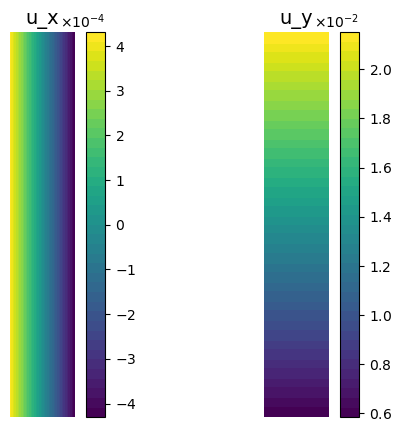

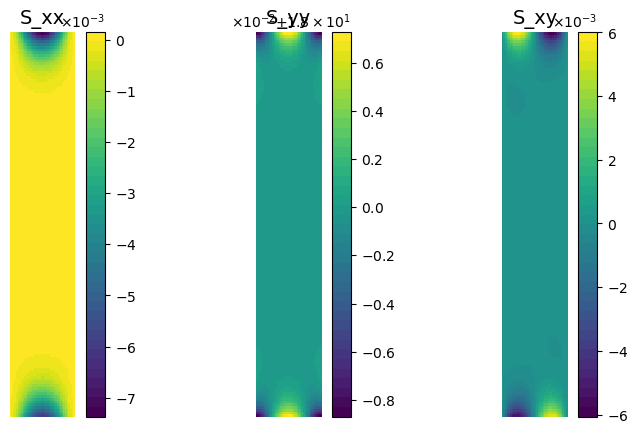

In [53]:
# Check interpolation (full specimen)
# #x_plot = np.linspace(0, Lmax, n_mesh_x+17)
# #y_plot = np.linspace(0, Hmax, n_mesh_y-9)

# x_plot = np.linspace(0, Lmax, n_mesh_x)
# y_plot = np.linspace(0, Hmax, n_mesh_y)

#check interpolation (ROI)
x_plot = np.linspace(offs_x, offs_x + x_max_ROI, n_mesh_x)
y_plot = np.linspace(offs_y, offs_y + y_max_ROI, n_mesh_y)

X, Y = np.meshgrid(x_plot, y_plot)

#full specimen
#X_mapped, Y_mapped = geometry_mapping(X, Y)

# X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# solution_plot = solution_fn(X_grid[:, 0], X_grid[:, 1])

# fig, ax = plt.subplots(1, 2, figsize=(6, 5))
# im = pcolor_plot(ax[0], X_mapped, Y_mapped, solution_plot[:,0].reshape(X.shape), "u_x",colormap=cmap)
# im = pcolor_plot(ax[1], X_mapped, Y_mapped, solution_plot[:,1].reshape(X.shape), "u_y",colormap=cmap)

# fig, ax = plt.subplots(1, 3, figsize=(9, 5))
# im = pcolor_plot(ax[0], X_mapped, Y_mapped, solution_plot[:,2].reshape(X.shape), "S_xx",colormap=cmap)
# im = pcolor_plot(ax[1], X_mapped, Y_mapped, solution_plot[:,3].reshape(X.shape), "S_yy",colormap=cmap)
# im = pcolor_plot(ax[2], X_mapped, Y_mapped, solution_plot[:,4].reshape(X.shape), "S_xy",colormap=cmap)

#ROI
X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

solution_plot = solution_fn(X_grid[:, 0], X_grid[:, 1])

fig, ax = plt.subplots(1, 2, figsize=(6, 5))
im = pcolor_plot(ax[0], X, Y, solution_plot[:,0].reshape(X.shape), "u_x",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, solution_plot[:,1].reshape(X.shape), "u_y",colormap=cmap)

fig, ax = plt.subplots(1, 3, figsize=(9, 5))
im = pcolor_plot(ax[0], X, Y, solution_plot[:,2].reshape(X.shape), "S_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, solution_plot[:,3].reshape(X.shape), "S_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, solution_plot[:,4].reshape(X.shape), "S_xy",colormap=cmap)


[[ 0.00043067  0.00040863  0.00038658 ... -0.00038658 -0.00040863
  -0.00043068]
 [ 0.0004307   0.00040864  0.00038659 ... -0.0003866  -0.00040865
  -0.0004307 ]
 [ 0.00043069  0.00040864  0.00038658 ... -0.00038659 -0.00040864
  -0.0004307 ]
 ...
 [ 0.00043078  0.00040873  0.00038667 ... -0.00038667 -0.00040873
  -0.00043078]
 [ 0.0004308   0.00040875  0.0003867  ... -0.0003867  -0.00040875
  -0.0004308 ]
 [ 0.0004308   0.00040876  0.00038671 ... -0.00038672 -0.00040876
  -0.00043081]]


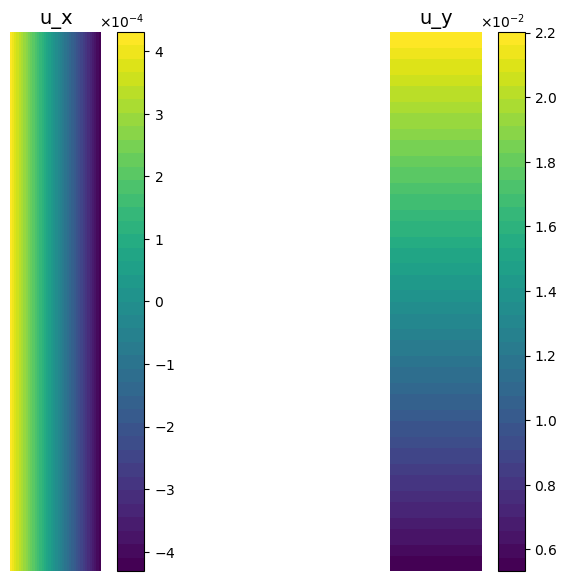

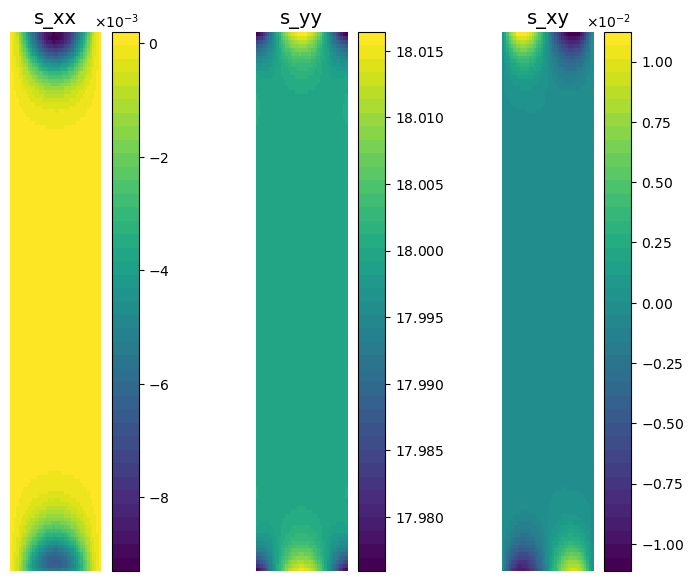

In [ ]:
# TODO ROI here?


# Check interpolation


#variables FEM
R = 20
Hmax = 110
n_mesh = 1 #lc

theta = np.arccos(15/R)
b = 10
indent_x = R - (R * np.cos(theta))
indent_y = R * np.sin(theta)
Lmax = 2*indent_x + b
free_length = 110
L_u = 60

L_c = free_length - (2*indent_y)
H_clamp = 0

total_points_vert = 140 #see geometry mapping code
total_points_hor = 40

x_max_FEM = (2*indent_x) + b
y_max_FEM = 2*H_clamp + 2*indent_y + L_c

#ROI positioning
offs_x = indent_x
offs_y = indent_y + H_clamp + (L_c-L_u)/2
x_max_ROI = b
y_max_ROI = L_u

n_DIC = 100

#x_plot = np.linspace(0, Lmax, n_mesh_x+17)
#y_plot = np.linspace(0, Hmax, n_mesh_y-9)
x_plot = np.linspace(offs_x, offs_x + x_max_ROI , 40)
y_plot = np.linspace(offs_y, offs_y + y_max_ROI , 140)
x_points = np.linspace(0, 20, 40)
y_points= np.linspace(25, 85, 140)
X_points, Y_points = np.meshgrid(x_points, y_points)
x_grid_points = np.hstack((X_points.flatten()[:, None], Y_points.flatten()[:, None]))

X, Y = np.meshgrid(x_plot, y_plot)
#X, Y = geometry_mapping(X, Y)
X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

solution_plot = solution_fn(x_grid_points[:, 0], x_grid_points[:, 1])

print(solution_plot[:,0].reshape(X.shape))

fig, ax = plt.subplots(1, 2, figsize=(9, 7))
im = pcolor_plot(ax[0], X, Y, solution_plot[:,0].reshape(X.shape), "u_x",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, solution_plot[:,1].reshape(X.shape), "u_y",colormap=cmap)

fig, ax = plt.subplots(1, 3, figsize=(9, 7))
im = pcolor_plot(ax[0], X, Y, solution_plot[:,2].reshape(X.shape), "s_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, solution_plot[:,3].reshape(X.shape), "s_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, solution_plot[:,4].reshape(X.shape), "s_xy",colormap=cmap)

5.0
25.0
15.0
85.0
[[ 0.00028704  0.00027235  0.00025767 ... -0.0002566  -0.00027128
  -0.00028597]
 [ 0.00028707  0.00027239  0.0002577  ... -0.00025657 -0.00027126
  -0.00028594]
 [ 0.0002871   0.00027241  0.00025772 ... -0.00025653 -0.00027121
  -0.0002859 ]
 ...
 [ 0.00029018  0.00027549  0.0002608  ... -0.00025357 -0.00026826
  -0.00028295]
 [ 0.00029023  0.00027554  0.00026084 ... -0.00025358 -0.00026828
  -0.00028297]
 [ 0.00029026  0.00027557  0.00026088 ... -0.00025358 -0.00026828
  -0.00028296]]


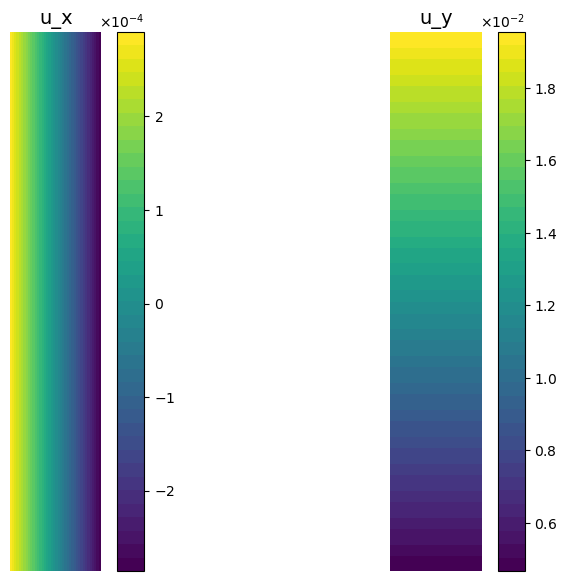

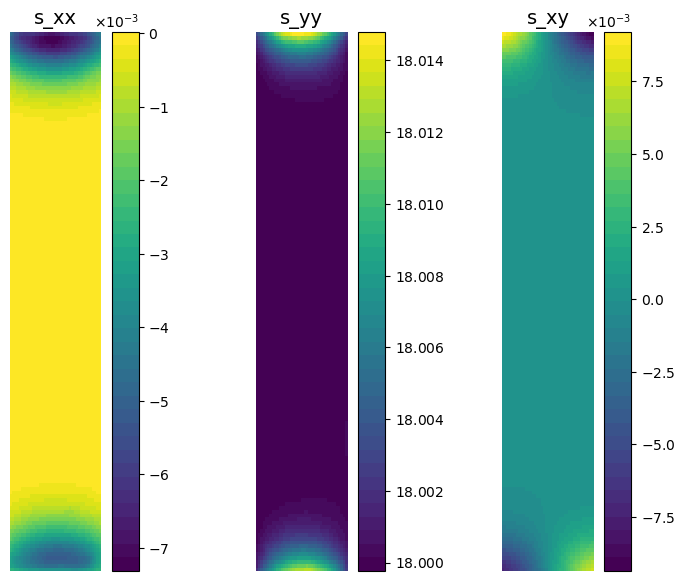

In [17]:
# Check interpolation


#variables FEM
R = 20
Hmax = 110
n_mesh = 1 #lc

theta = np.arccos(15/R)
b = 10
indent_x = R - (R * np.cos(theta))
indent_y = R * np.sin(theta)
Lmax = 2*indent_x + b
free_length = 110
L_u = 60

L_c = free_length - (2*indent_y)
H_clamp = 0

total_points_vert = 140 #see geometry mapping code
total_points_hor = 40

x_max_FEM = (2*indent_x) + b
y_max_FEM = 2*H_clamp + 2*indent_y + L_c

#ROI positioning
offs_x = indent_x
offs_y = indent_y + H_clamp + (L_c-L_u)/2
x_max_ROI = b
y_max_ROI = L_u

n_DIC = 100

#x_plot = np.linspace(0, Lmax, n_mesh_x+17)
#y_plot = np.linspace(0, Hmax, n_mesh_y-9)
x_plot = np.linspace(offs_x, offs_x + x_max_ROI , 40)
y_plot = np.linspace(offs_y, offs_y + y_max_ROI , 140)

print(offs_x)
print(offs_y)
print(offs_x + x_max_ROI)
print(offs_y + y_max_ROI)

X, Y = np.meshgrid(x_plot, y_plot)
#X, Y = geometry_mapping(X, Y)
X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

solution_plot = solution_fn(X_grid[:, 0], X_grid[:, 1])

print(solution_plot[:,0].reshape(X.shape))

fig, ax = plt.subplots(1, 2, figsize=(9, 7))
im = pcolor_plot(ax[0], X, Y, solution_plot[:,0].reshape(X.shape), "u_x",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, solution_plot[:,1].reshape(X.shape), "u_y",colormap=cmap)

fig, ax = plt.subplots(1, 3, figsize=(9, 7))
im = pcolor_plot(ax[0], X, Y, solution_plot[:,2].reshape(X.shape), "s_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, solution_plot[:,3].reshape(X.shape), "s_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, solution_plot[:,4].reshape(X.shape), "s_xy",colormap=cmap)
